In [1]:
%load_ext autoreload
%autoreload 2
from paths import *
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.utils
import torch.distributions
import numpy as np
import dill
from tqdm import tqdm
from datetime import date
import os, sys
import datetime as dt
from matplotlib import pyplot as plt
import matplotlib
from IPython.display import Image, display, clear_output
from scipy import stats
from src.SERS_dataset import IterDataset, SERSDataset, SERSDatasetNPY
# import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda = torch.cuda.is_available()

c:\Users\andre\OneDrive - Danmarks Tekniske Universitet\Bachelorprojekt\Code\bachelor-project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def plot_loss(epoch, epochs, loss, loss_kl, loss_recon, loss_test, loss_kl_test, loss_recon_test, z, x, recons, recons_mu, mu, logvar, tmp_img="plots_vae_temp.png"):
    """ Plot the loss over time
    
    Args:
        loss (list): The loss over time

    Returns:
        None
    """
    x = x.to('cpu').detach().numpy()
    recons = recons.to('cpu').detach().numpy()
    recons_mu = recons_mu.to('cpu').detach().numpy()
    mu = mu.to('cpu').detach().numpy()
    logvar = logvar.to('cpu').detach().numpy()
    sigma = np.exp(0.5*logvar)
    z = z.to('cpu').detach().numpy()

    width = 3
    fig, axs = plt.subplots(3, width, figsize=(15, 15))

    # Figure title above all subplots
    fig.suptitle(f"Epoch {epoch} of {epochs}")

    # Plot loss
    axs[0, 0].plot(loss, label="Total loss")
    axs[0, 0].set_xlabel("Iteration")
    axs[0, 0].set_ylabel("Loss")

    axs[0, 0].plot(loss_kl, label = "beta KL loss")
    axs[0, 0].set_xlabel("Iteration")
    axs[0, 0].set_ylabel("Loss")

    axs[0, 0].plot(loss_recon, label = "Reconstruction loss")
    axs[0, 0].set_xlabel("Iteration")
    axs[0, 0].set_ylabel("Loss")

    axs[0, 0].set_title("Train loss")
    axs[0, 0].legend()

    # Plot test loss
    axs[0, 1].plot(loss_test, label="Total loss")
    axs[0, 1].set_title("Total loss")
    axs[0, 1].set_xlabel("Iteration")
    axs[0, 1].set_ylabel("Loss")

    axs[0, 1].plot(loss_kl_test, label = "beta KL loss")
    axs[0, 1].set_title("KL loss")
    axs[0, 1].set_xlabel("Iteration")
    axs[0, 1].set_ylabel("Loss")

    axs[0, 1].plot(loss_recon_test, label = "Reconstruction loss")
    axs[0, 1].set_xlabel("Iteration")
    axs[0, 1].set_ylabel("Loss")
    axs[0, 1].set_title("Test loss")

    axs[0, 1].legend()

    

    # get color from color map 
    colors = plt.cm.rainbow(np.linspace(0, 1, len(mu)))
    # scatter plot with different colors
    axs[0,2].scatter(z[:, 0], z[:, 1], c=colors, s = 10, alpha=0.9)

    # plot ellipses for each mu and sigma
    for i in range(len(mu)):
        mu_x = mu[i][0]
        mu_y = mu[i][1]
        sigma_x = sigma[i][0]
        sigma_y = sigma[i][1]
        # plot ellipse
        # axs[0,2].scatter(mu_x, mu_y, color = colors[i], s=1, alpha=0.5)
        ellipse = matplotlib.patches.Ellipse((mu_x, mu_y), 2*sigma_x, 2*sigma_y, alpha=0.08, color=colors[i])
        axs[0,2].add_patch(ellipse)

    axs[0,2].set_xlabel("z1")
    axs[0,2].set_ylabel("z2")
    axs[0,2].set_title("Latent space")


    colors = plt.cm.rainbow(np.linspace(0, 1, len(mu[0])))
    for j in range(width):
        axs[1, j].plot(x[j].flatten(), label="Original")
        axs[1, j].plot(recons[j].flatten(), label="Reconstruction")
        axs[1, j].plot(recons_mu[j].flatten(), label="Reconstruction mu")
        axs[1, j].set_title("Reconstruction of SERS spectra")
        axs[1, j].set_xlabel("Wavenumber")
        axs[1, j].set_ylabel("Intensity (a.u.)")
        axs[1, j].legend()

        for i in range(len(mu[0]-1)):
            axs[2, j].axvline(mu[j][i], linestyle='--', alpha=0.5, color=colors[i])
            linsp = np.linspace(np.min(mu[j])-sigma[j][np.argmin(mu[j])]*3, np.max(mu[j])+sigma[j][np.argmax(mu[j])]*3, 100)
            axs[2, j].plot(linsp, stats.norm.pdf(linsp, mu[j][i], sigma[j][i]), label="Normal distribution", color=colors[i])
            axs[2, j].plot(z[j][i], 0, 'o', color=colors[i], alpha=0.5)
            axs[2, j].set_title("Latent space")
            axs[2, j].set_xlabel("Wavenumber")
        

    plt.tight_layout()
    plt.savefig(tmp_img)
    plt.close(fig)
    display(Image(filename=tmp_img))
    clear_output(wait=True)

    os.remove(tmp_img)


In [3]:

class Autoencoder(nn.Module):
    """ The autoencoder is a combination of the encoder and decoder
    
    Args:
        encoder (nn.Module): The encoder to use
        decoder (nn.Module): The decoder to use
        latent_dims (int): The number of latent dimensions to use
    """
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()

        self.encoder1 = nn.Linear(in_features=500, out_features=128).to(device)
        self.encoder2 = nn.ReLU().to(device)
        self.encoder_mu = nn.Linear(in_features=128, out_features=latent_dims).to(device)
        self.encoder_logvar = nn.Linear(in_features=128, out_features=latent_dims).to(device)


        self.decoder1 = nn.Linear(in_features=latent_dims, out_features=128).to(device)
        self.decoder2 = nn.ReLU().to(device)
        self.decoder3 = nn.Linear(in_features=128, out_features=500).to(device)

        self.kl = 0


    def encode(self, x):
        h1 = self.encoder1(x)
        h2 = self.encoder2(h1)
        mu = self.encoder_mu(h2)
        logvar = self.encoder_logvar(h2)
        # torch rsample
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std

        self.kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
        
        return z, mu, logvar     
    
    def decode(self, z):
        h1 = self.decoder1(z)
        h2 = self.decoder2(h1)
        return self.decoder3(h2)

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        return self.decode(z)

In [4]:
def train(autoencoder, data, test_loader, optimizer="SGD", epochs=30, num_iterations_per_epoch = None, lr = 0.001, beta=1):
    """ Train the autoencoder on the data for a number of epochs
    
    Args:
        autoencoder (nn.Module): The autoencoder to train
        data (DataLoader): The data to train on
        epochs (int): The number of epochs to train for

    Returns:
        nn.Module: The trained autoencoder
    """

    # The optimizer is defined 
    if optimizer == 'adam':
        opt = torch.optim.Adam(autoencoder.parameters())
    else: 
        opt = torch.optim.SGD(autoencoder.parameters(), lr=10)

    # The loss function is defined
    loss_function = nn.MSELoss()

    # Lists to store the loss values
    train_loss = []
    test_loss = []
    train_loss_kl = []
    test_loss_kl = []
    train_loss_recon = []
    test_loss_recon = []

    x_test, y_test = next(iter(test_loader))


    # Loop through epochs 
    for epoch in range(epochs):
        batch_loss = []
        batch_loss_kl = []
        batch_loss_recon = []
        valid_loss = []
        valid_loss_kl = []
        valid_loss_recon = []        
        # Loop through batches of train data
        for i, (x, y) in enumerate(data):
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            recon_loss = loss_function(x_hat, x)
            # recon_loss = (x - x_hat).pow(2).mean(axis=1).mean()
            kl = autoencoder.kl * beta

            loss = recon_loss + kl
            loss.backward()
            opt.step()

            batch_loss.append(loss.item())
            batch_loss_kl.append(kl.item())
            batch_loss_recon.append(recon_loss.item())
            if i and i == num_iterations_per_epoch:
                break

        train_loss.append(np.mean(batch_loss))
        train_loss_kl.append(np.mean(batch_loss_kl))
        train_loss_recon.append(np.mean(batch_loss_recon))
        # print("train_loss: ", np.mean(batch_loss), "train_loss_KL: ", np.mean(batch_loss_kl), "train_loss_recon: ", np.mean(batch_loss_recon))

        
        # wandb.log({"train_loss": np.mean(batch_loss), "train_loss_KL": np.mean(batch_loss_kl), "train_loss_recon": np.mean(batch_loss_recon)})
 
        with torch.no_grad():
            autoencoder.eval()
            x, y = next(iter(test_loader))
            x = x.to(device)
            z, mu, logvar = autoencoder.encode(x)
            x_hat = autoencoder.decode(z)
            x_hat_mu = autoencoder.decode(mu)   

            recon_loss = loss_function(x_hat, x)
            kl = autoencoder.kl * beta
            loss = recon_loss + kl


            z_test, mu_test, logvar_test = autoencoder.encode(x_test.to(device))
            x_hat_test = autoencoder.decode(z_test)
            x_hat_mu_test = autoencoder.decode(mu_test)


            valid_loss.append(loss.item())
            valid_loss_kl.append(kl.item())
            valid_loss_recon.append(recon_loss.item())
           

        test_loss.append(np.mean(valid_loss))
        test_loss_kl.append(np.mean(valid_loss_kl))
        test_loss_recon.append(np.mean(valid_loss_recon))

        if epoch % 9 == 0:
            plot_loss(epoch+1, epochs, train_loss, train_loss_kl, train_loss_recon, test_loss, test_loss_kl, test_loss_recon,
            z_test, x_test, x_hat_test, x_hat_mu_test, mu_test, logvar_test)
        # print("test_loss: ", np.mean(valid_loss), "test_loss_KL: ", np.mean(valid_loss_kl), "test_loss_recon: ", np.mean(valid_loss_recon))
        # wandb.log({"test_loss": np.mean(valid_loss), "test_loss_KL": np.mean(valid_loss_kl), "test_loss_recon": np.mean(valid_loss_recon)})

    return autoencoder, train_loss, test_loss

In [5]:
batch_size = 100
# from generate_data import SERS_generator_function
from src.SERS_dataset import SERSDataset, IterDataset, SERSDatasetNPY

# dset_train = IterDataset(SERS_generator_function(single_spectrum=True, num_peaks=1, num_hotspots=1))
# dset_test = IterDataset(SERS_generator_function(single_spectrum=True, num_peaks=1, num_hotspots=1))

dset_train = SERSDatasetNPY(f"{data_dir}/randomized_alpha.npy")
dset_test = SERSDatasetNPY(f"{data_dir}/randomized_alpha_test.npy")

# Load the SERS dataset
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=batch_size, pin_memory=cuda)
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=batch_size, pin_memory=cuda)

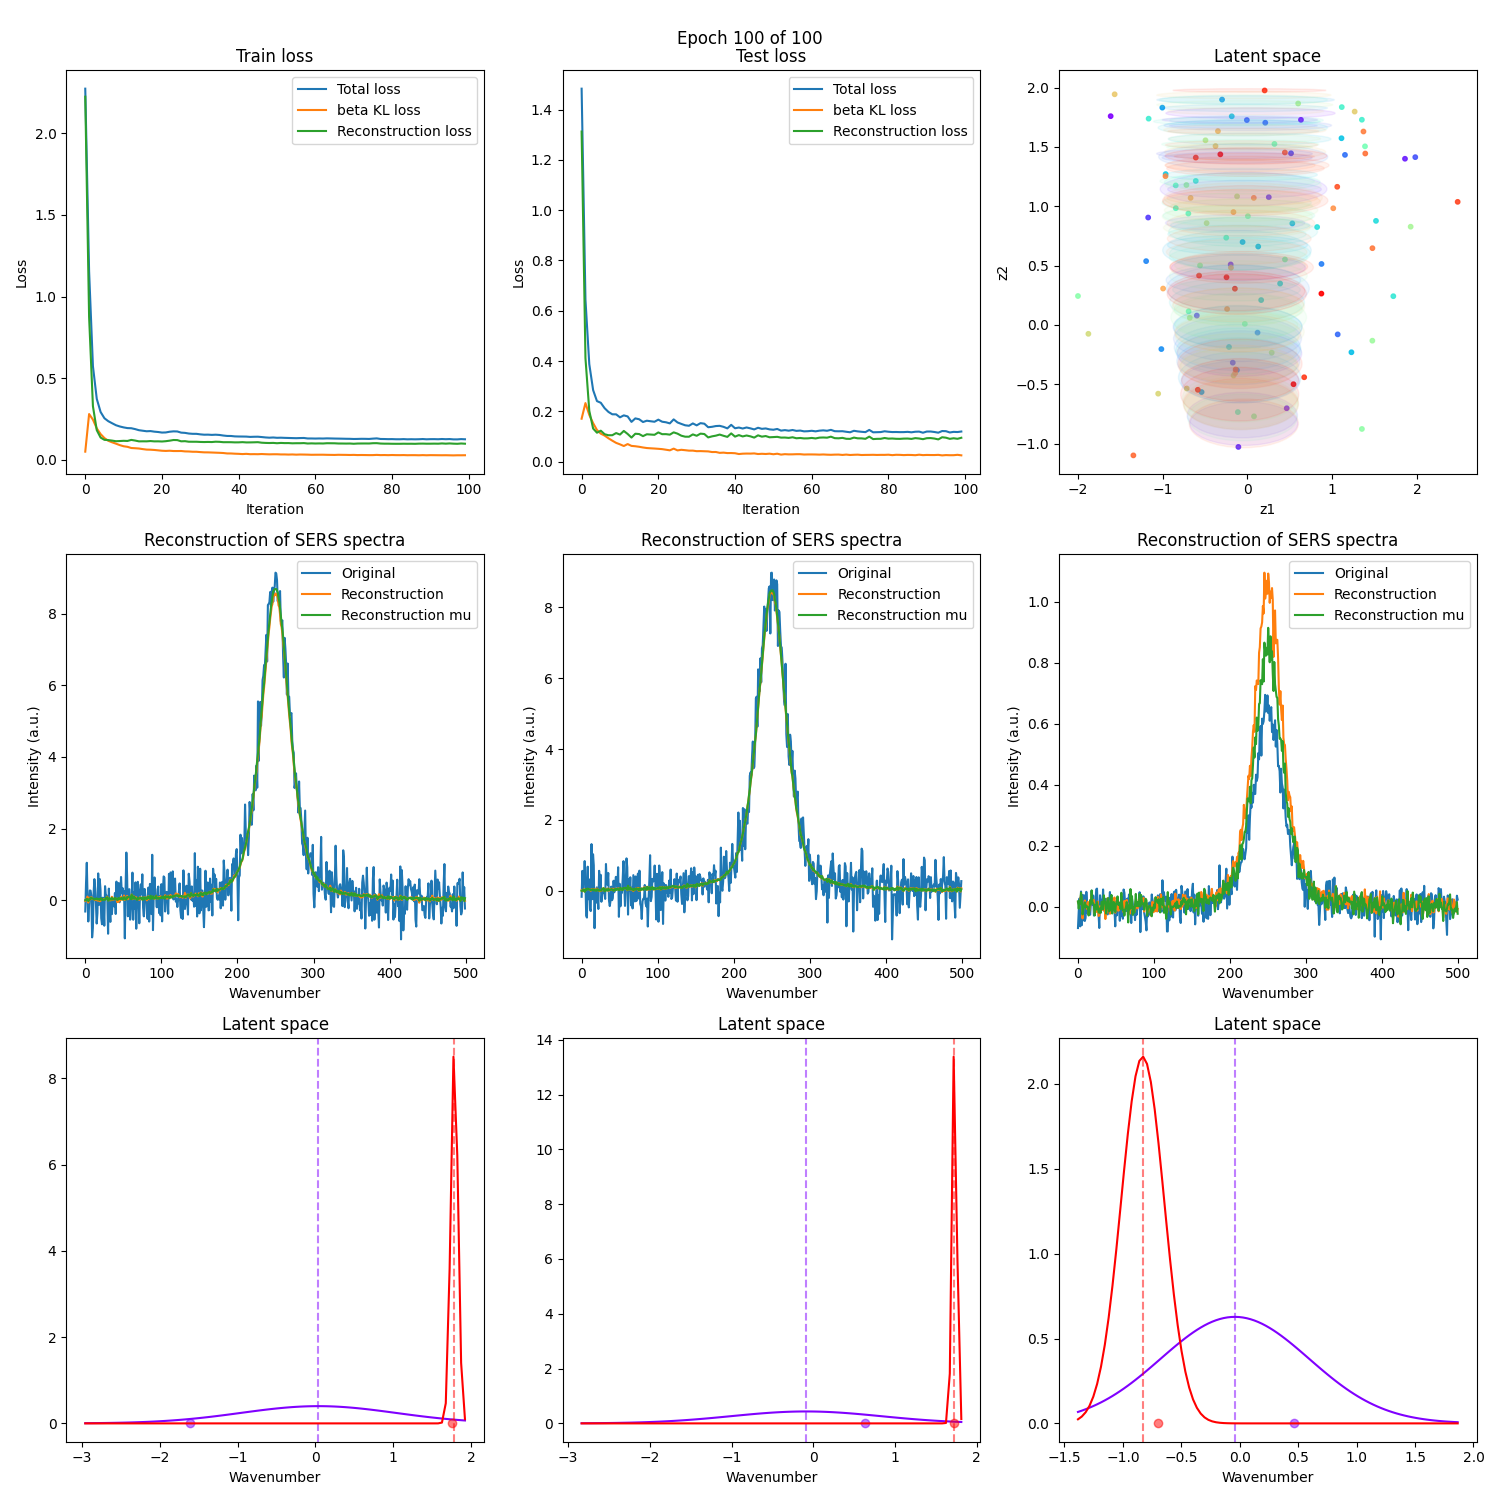

In [10]:
latent_dims = 2
epochs = 100
num_batches_per_epoch = 100
learning_rate = 1e-2
optimizer = "adam"

autoencoder = Autoencoder(latent_dims).to(device) 

#==============================================================================
# Train the model
#==============================================================================

autoencoder, train_loss, test_loss = train(autoencoder, train_loader, test_loader, 
                                        optimizer=optimizer, epochs=epochs, 
                                        num_iterations_per_epoch=num_batches_per_epoch,
                                        lr=learning_rate,beta=0.01)


In [11]:
batch_size = 100
# from generate_data import SERS_generator_function
from src.SERS_dataset import SERSDataset, IterDataset, SERSDatasetNPY

# dset_train = IterDataset(SERS_generator_function(single_spectrum=True, num_peaks=1, num_hotspots=1))
# dset_test = IterDataset(SERS_generator_function(single_spectrum=True, num_peaks=1, num_hotspots=1))

dset_train = SERSDatasetNPY(f"{data_dir}/randomized_c.npy")
dset_test = SERSDatasetNPY(f"{data_dir}/randomized_c_test.npy")

# Load the SERS dataset
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=batch_size, pin_memory=cuda)
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=batch_size, pin_memory=cuda)

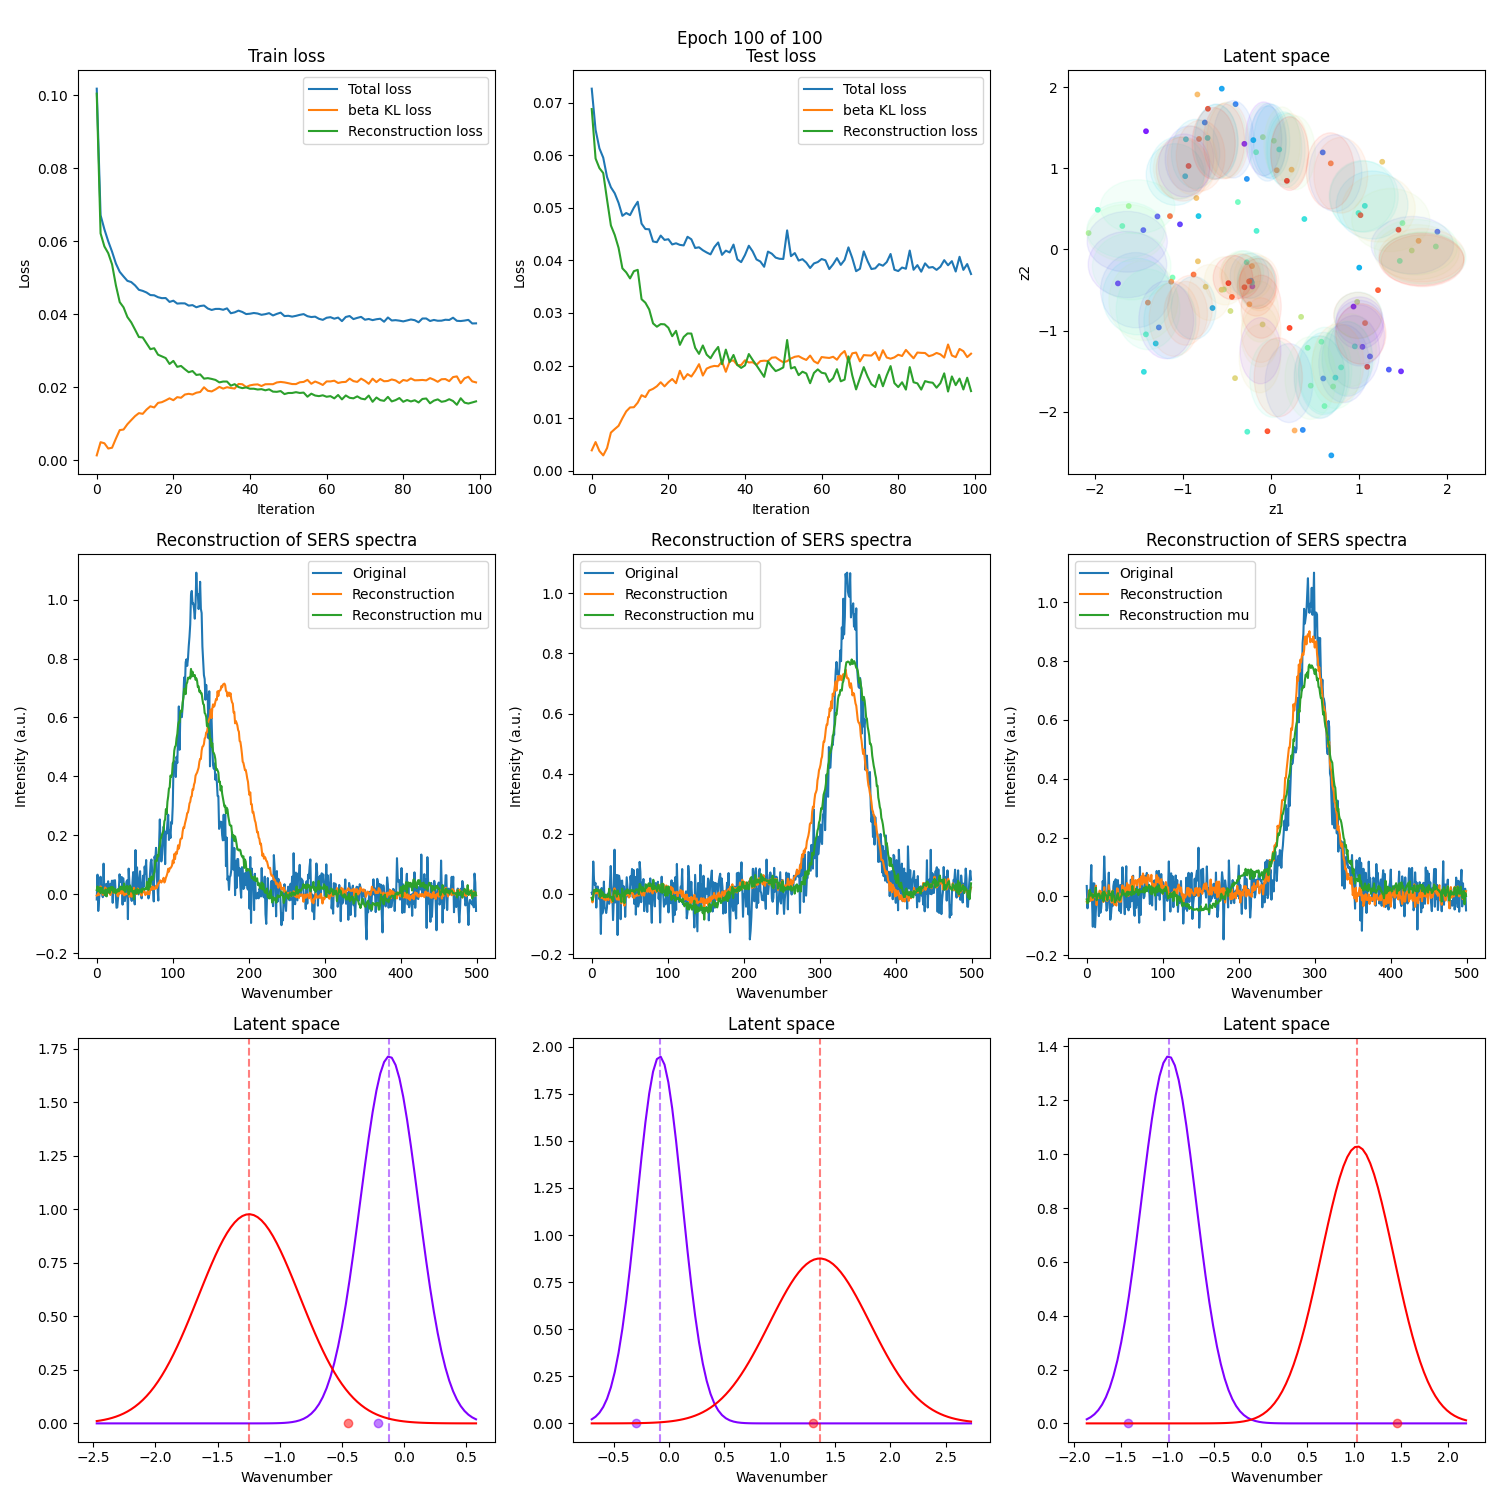

In [12]:
latent_dims = 2
epochs = 100
num_batches_per_epoch = 100
learning_rate = 1e-2
optimizer = "adam"

autoencoder = Autoencoder(latent_dims).to(device) 

#==============================================================================
# Train the model
#==============================================================================

autoencoder, train_loss, test_loss = train(autoencoder, train_loader, test_loader, 
                                        optimizer=optimizer, epochs=epochs, 
                                        num_iterations_per_epoch=num_batches_per_epoch,
                                        lr=learning_rate,beta=0.01)
